In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from selenium import webdriver as wb
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import datetime
import time
from wordcloud import WordCloud

## 비트코인과 안정자산, 위험자산의 상관관계 분석
- 데이터 산출 기간
    - 제도 편입 전 : 2014.09.01 ~ 2019.12.31
    - 제도 편입 후 : 2021.01.01 ~ 2024.06.06
- 안전자산 비교군 : 금, 달러
- 위험자산 비교군 : 원유
- 데이터 출처 : Yahoo Finance

In [2]:
# 기간
start_date = "2021-01-01"
end_date = "2024-06-06"
news_date_list = ["2022.03.28", "2022.11.14", "2023.04.03", "2024.01.08", "2024.03.25", "2024.05.06"]

# 종목
bitcoin = "BTC-USD"
gold = "GC=F"
usd = "EURUSD=X"
wti = "CL=F"

# 일간 티커 데이터 수집
def ticker_data(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de)
    result["change"] = result["Adj Close"].diff()
    result["daily_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna() # NaN 포함 행 삭제
    return result

# 주간 티커 데이터 수집
def ticker_data_wk(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de, interval = "1wk")
    result["weekly_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna()
    return result

# 일별 수정 종가 (Adj Close) 추출 함수
def daily_adj_close(tk_name, ds, de) :
    result = yf.download(tk_name, ds, de)
    return result["Adj Close"]

# 일별 수익률 (daily_return) 추출 함수
def daily_return_rate(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de)
    return result["daily_return"]

# 주간 수익률 (weekly_return) 추출 함수
def weekly_return_rate(tk_name, ds, de) :
    result = ticker_data_wk(tk_name, ds, de)
    return result["weekly_return"]

# 비트코인과 티커 간의 상관성 산출
def corr_bit(tk_name, ds, de) :
    result = weekly_return_rate("BTC-USD", ds, de) / weekly_return_rate(tk_name, ds, de)
    result = result.dropna()
    return result

# 계산식 for 선형 회귀
def line_ticker_2024(tk_name, ds, de) :
    tk2024 = ticker_data(tk_name, ds, de) # 제도 편입 후 기간의 티커 데이터 수집
    std2024 = tk2024[tk2024.index == "2024-06-04"] # 기준이 되는 날짜의 행 추출
    std2024 = std2024["Adj Close"].values[0] # 해당 행의 수정 종가
    result = (ticker_data(tk_name, ds, de)["Adj Close"] / std2024) * 100 # 티커의 수정 종가 컬럼과 연산
    return result

# 티커 생성 시 호출 함수
def ticker_call(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de) # 일간 티커 데이터 수집
    result["chg_rat_exp_2024"] = line_ticker_2024(tk_name, ds, de) # 선형 회귀 산출을 위해 연산된 컬럼 추가
    return result

# 선형 회귀 계수 산출
def lin_data(tk_name, ds, de) :
    bit_col = ticker_call(bitcoin, ds, de)["chg_rat_exp_2024"]
    tk_col = ticker_call(tk_name, ds, de)["chg_rat_exp_2024"]
    
    result = pd.concat([bit_col, tk_col], axis = 1)
    result.columns = ["bit", "tk"]
    result = result.dropna()
    
    model = stats.linregress(result["bit"], result["tk"])
    dict_lin = {
        "slope" : model.slope,
        "intercept" : model.intercept,
        "rvalue" : model.rvalue,
        "pvalue" : model.pvalue,
        "stderr" : model.stderr,
        "intercept_stderr" : model.intercept_stderr
    }
    result_lin = pd.DataFrame(list(dict_lin.values()), index = dict_lin.keys())
    return result_lin

In [3]:
# 비트코인의 일간 티커 데이터 수집
bit_ticker = ticker_call(bitcoin, start_date, end_date)
bit_ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,change,daily_return,chg_rat_exp_2024
Date,,,,,,,,,
2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,2753.115234,9.372578,45.526831
2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,654.755859,2.038007,46.454671
2021-01-04,32810.949219,33440.218750,28722.755859,31971.914062,31971.914062,81163475344,-810.109375,-2.471200,45.306683
2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,2020.515625,6.319658,48.169911
2021-01-06,34013.613281,36879.699219,33514.035156,36824.363281,36824.363281,75289433811,2831.933594,8.331071,52.182980
...,...,...,...,...,...,...,...,...,...
2024-06-01,67489.609375,67839.765625,67386.195312,67706.937500,67706.937500,11641495604,215.523438,0.319335,95.945985
2024-06-02,67710.273438,68409.164062,67315.523438,67751.601562,67751.601562,17110588415,44.664062,0.065967,96.009277
2024-06-03,67753.898438,70230.820312,67589.835938,68804.781250,68804.781250,32401285324,1053.179688,1.554472,97.501714


In [4]:
# 비교군 일간 티커 데이터 수집
ticker = ticker_call(usd, start_date, end_date)
ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,change,daily_return,chg_rat_exp_2024
Date,,,,,,,,,
2021-01-04,1.224905,1.230999,1.217137,1.225070,1.225070,0,0.007043,0.578221,112.315621
2021-01-05,1.225295,1.229483,1.224995,1.225160,1.225160,0,0.000090,0.007356,112.323884
2021-01-06,1.229861,1.235025,1.226693,1.230027,1.230027,0,0.004868,0.397299,112.770146
2021-01-07,1.233776,1.234568,1.224665,1.234111,1.234111,0,0.004083,0.331976,113.144516
2021-01-08,1.226873,1.228215,1.221493,1.227144,1.227144,0,-0.006966,-0.564484,112.505833
...,...,...,...,...,...,...,...,...,...
2024-05-30,1.080182,1.084599,1.078900,1.080182,1.080182,0,-0.005005,-0.461233,99.032162
2024-05-31,1.083541,1.088258,1.081163,1.083541,1.083541,0,0.003359,0.310973,99.340126
2024-06-03,1.085305,1.089087,1.082802,1.085305,1.085305,0,0.001764,0.162794,99.501846


## 선형 회귀

In [5]:
# 선형 회귀 계수 산출
gold_lin = lin_data(gold, start_date, end_date)
usd_lin = lin_data(usd, start_date, end_date)
wti_lin = lin_data(wti, start_date, end_date)

df_lin = pd.concat([gold_lin, usd_lin, wti_lin], axis = 1)
df_lin.columns = ["Gold", "EUR/USD", "WTI"]
df_lin

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,Gold,EUR/USD,WTI
slope,1.425926e-01,1.379034e-01,-2.170310e-01
intercept,7.359487e+01,9.373964e+01,1.206953e+02
rvalue,4.476186e-01,5.072604e-01,-2.473752e-01
pvalue,1.187240e-43,1.459521e-59,1.800018e-13
stderr,9.719387e-03,7.848884e-03,2.900393e-02
intercept_stderr,5.599123e-01,4.517490e-01,1.670852e+00


## 데이터 시각화

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


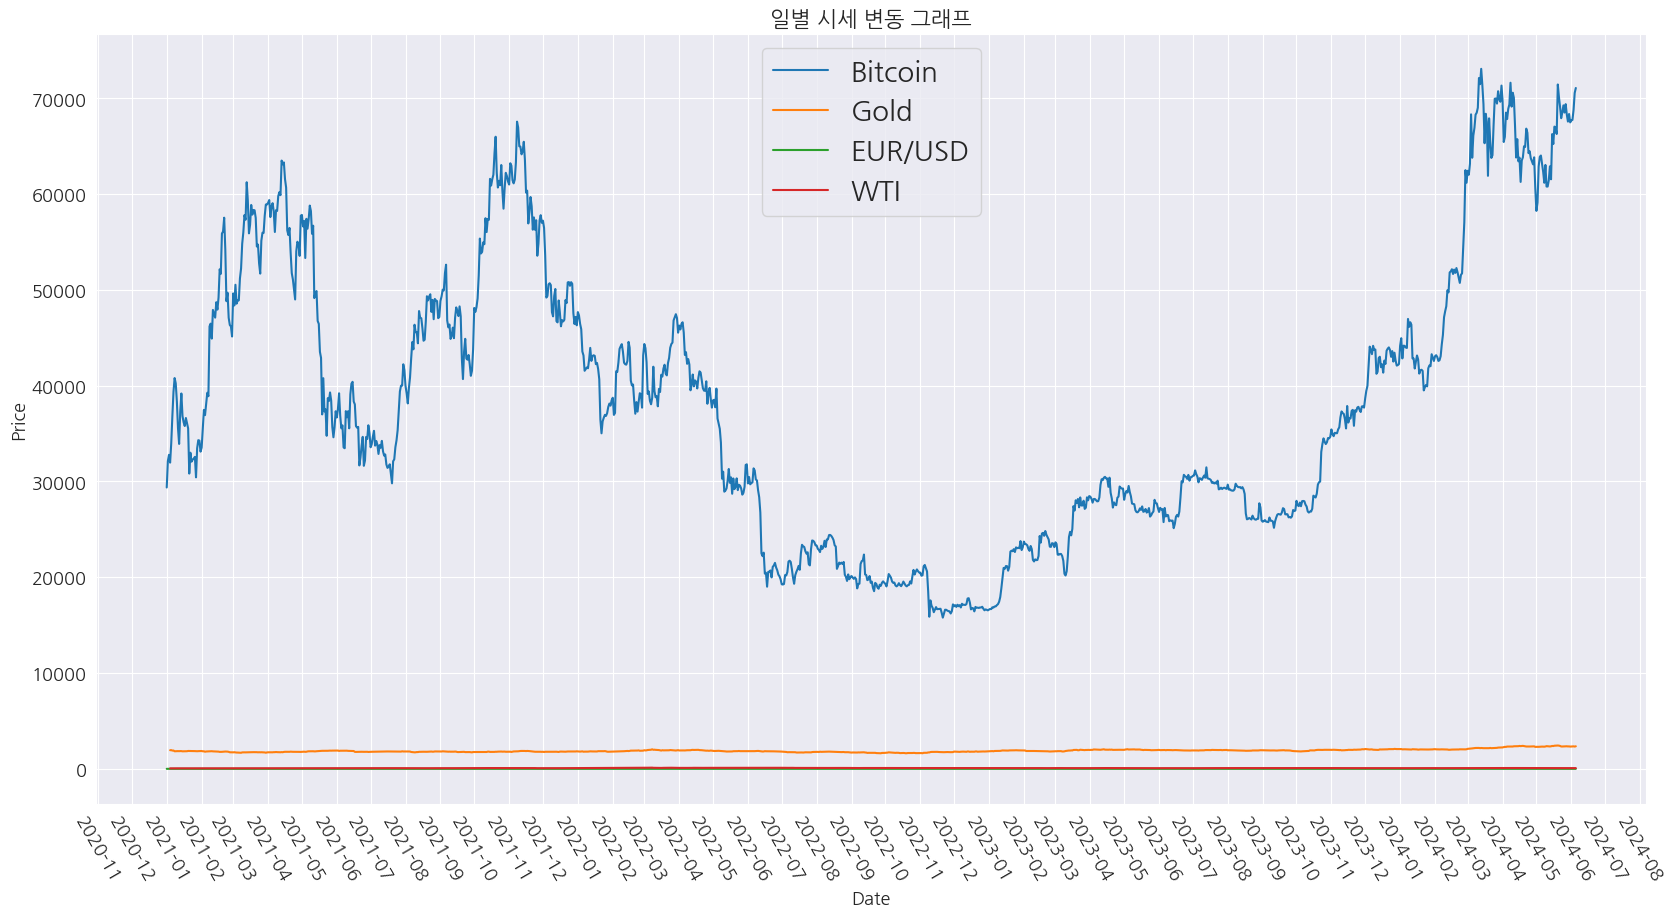

In [6]:
# daily price change graph
y1 = daily_adj_close(bitcoin, start_date, end_date)
y2 = daily_adj_close(gold, start_date, end_date)
y3 = daily_adj_close(usd, start_date, end_date)
y4 = daily_adj_close(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(y1.index, y1, label = "Bitcoin")
plt.plot(y2.index, y2, label = "Gold")
plt.plot(y3.index, y3, label = "EUR/USD")
plt.plot(y4.index, y4, label = "WTI")
plt.legend(loc = "best", prop = {"size":20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("일별 시세 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


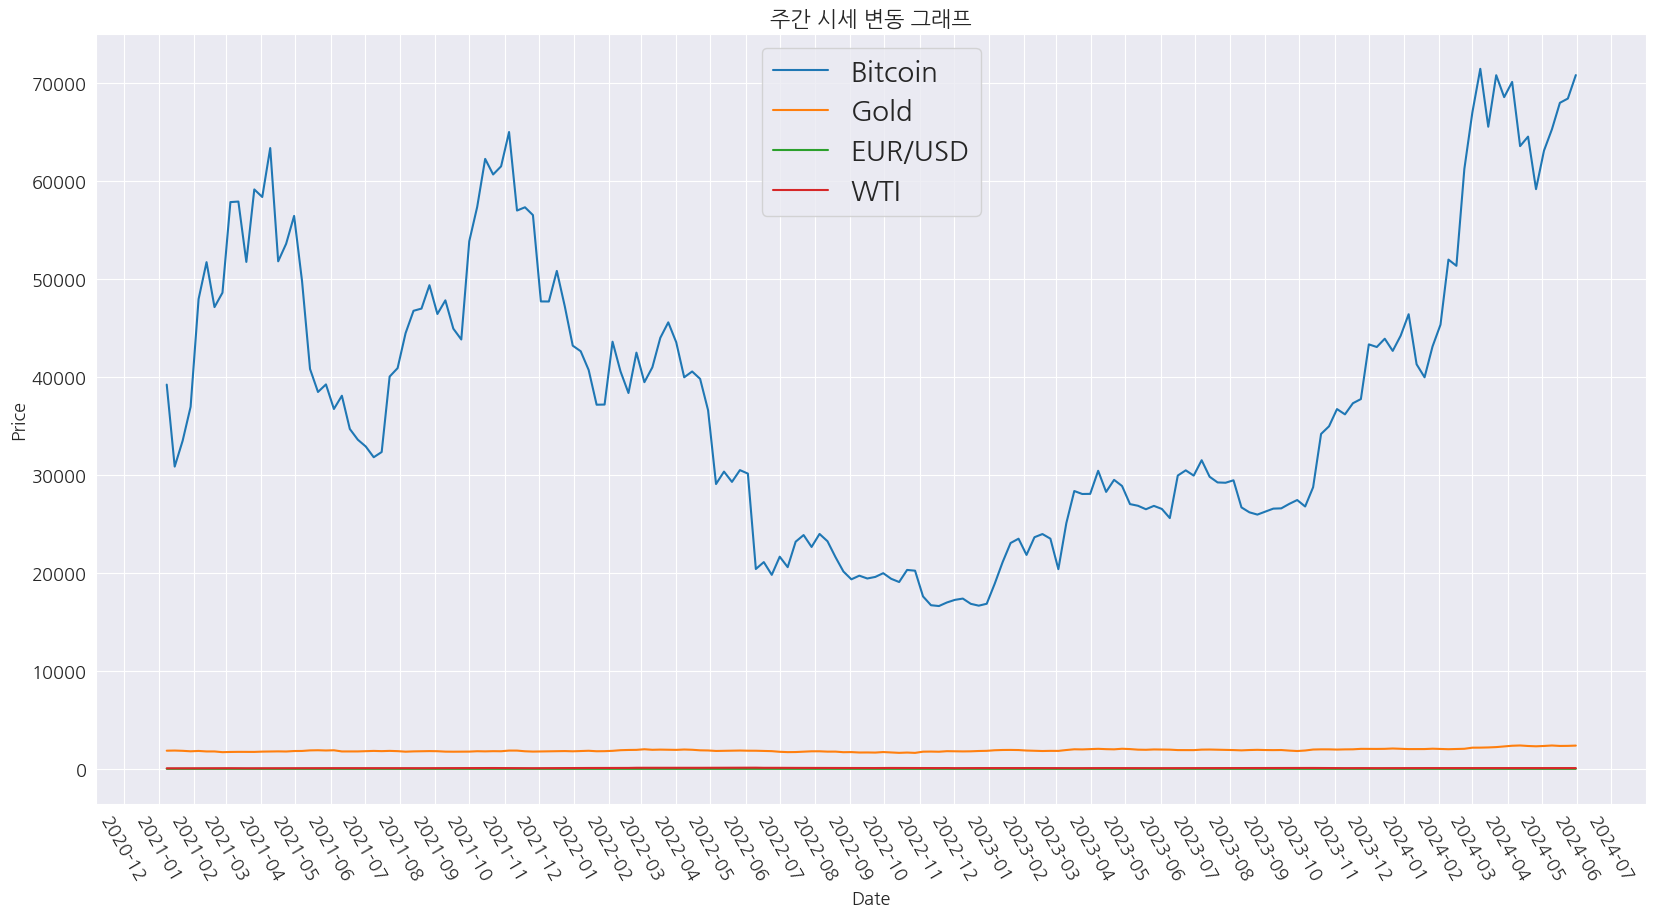

In [7]:
# weekly price change graph
y1_wk = ticker_data_wk(bitcoin, start_date, end_date)["Adj Close"]
y2_wk = ticker_data_wk(gold, start_date, end_date)["Adj Close"]
y3_wk = ticker_data_wk(usd, start_date, end_date)["Adj Close"]
y4_wk = ticker_data_wk(wti, start_date, end_date)["Adj Close"]

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(y1_wk.index, y1_wk, label = "Bitcoin")
plt.plot(y2_wk.index, y2_wk, label = "Gold")
plt.plot(y3_wk.index, y3_wk, label = "EUR/USD")
plt.plot(y4_wk.index, y4_wk, label = "WTI")
plt.legend(loc = "best", prop = {"size":20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("주간 시세 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


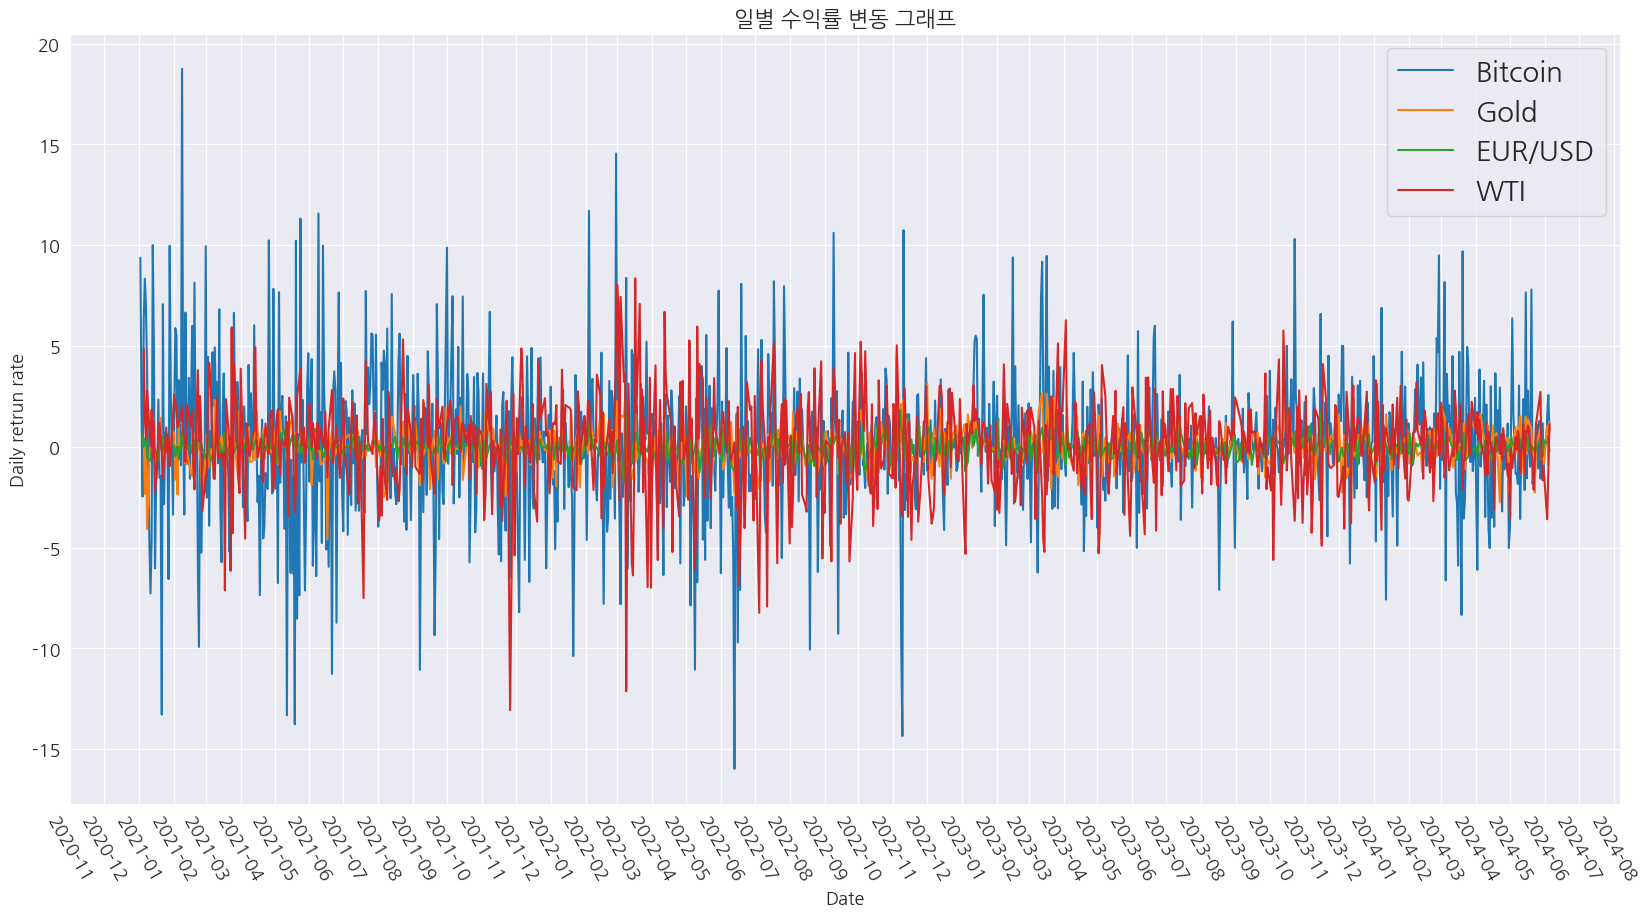

In [8]:
# daily return rate change graph
# 일별 수익률(=증감률)의 변동성 확인
d_y1 = daily_return_rate(bitcoin, start_date, end_date)
d_y2 = daily_return_rate(gold, start_date, end_date)
d_y3 = daily_return_rate(usd, start_date, end_date)
d_y4 = daily_return_rate(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(d_y1.index, d_y1, label = "Bitcoin")
plt.plot(d_y2.index, d_y2, label = "Gold")
plt.plot(d_y3.index, d_y3, label = "EUR/USD")
plt.plot(d_y4.index, d_y4, label = "WTI")
plt.legend(loc = "best", prop = {"size":20})
plt.xlabel("Date")
plt.ylabel("Daily retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("일별 수익률 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


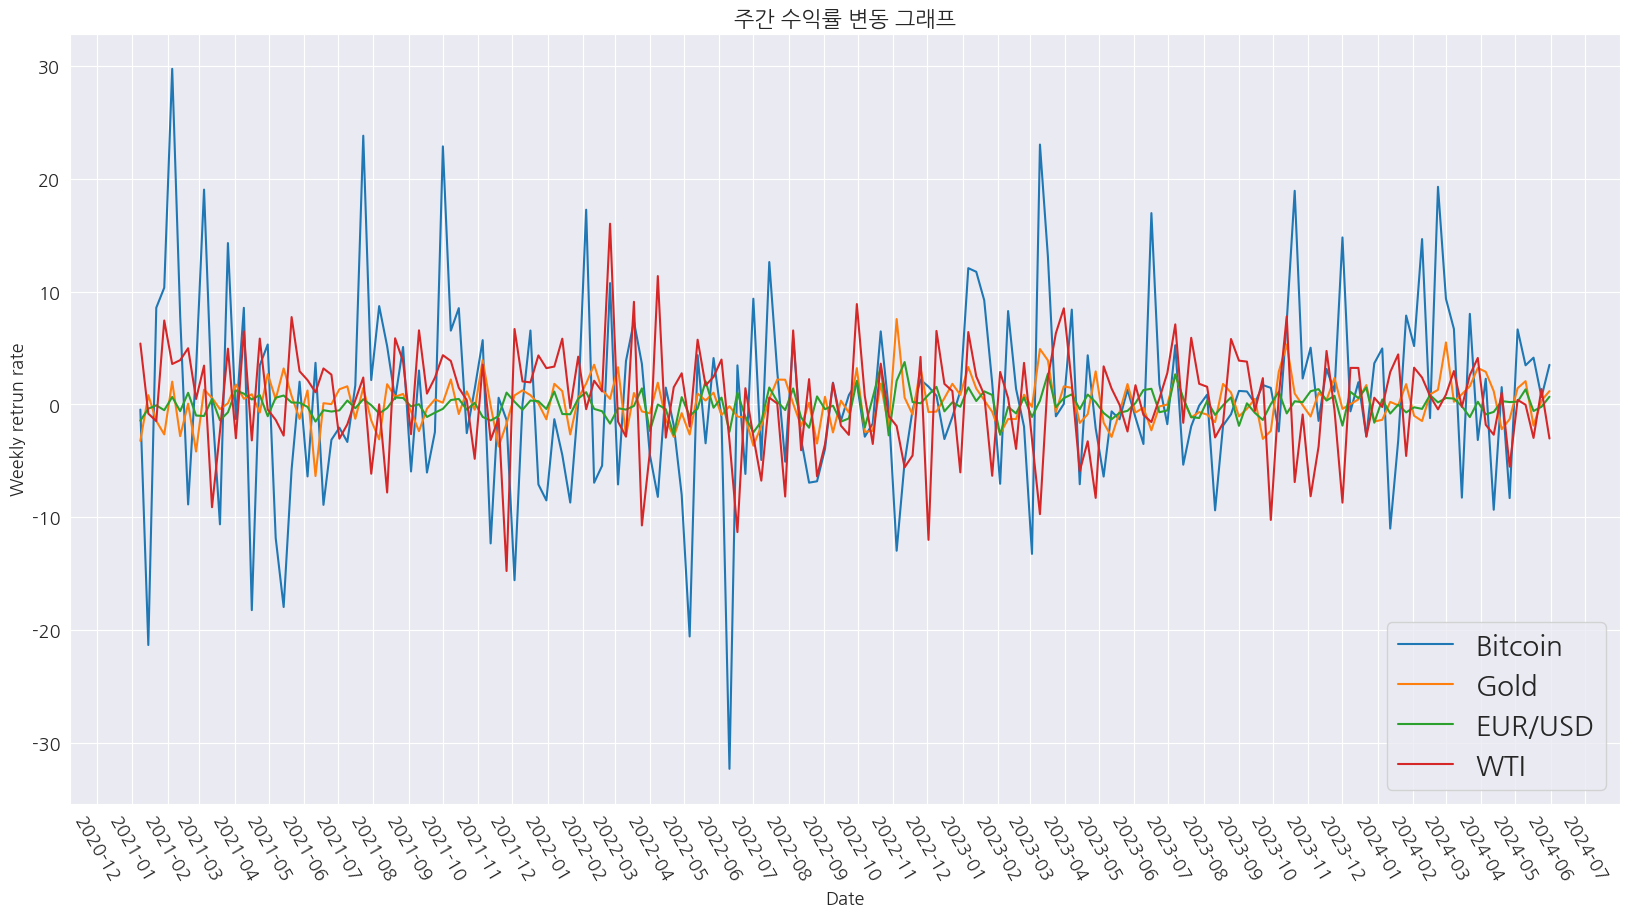

In [9]:
# weekly return rate change graph
# 주간 수익률 (=증감률)의 변동성 확인
w_y1 = weekly_return_rate(bitcoin, start_date, end_date)
w_y2 = weekly_return_rate(gold, start_date, end_date)
w_y3 = weekly_return_rate(usd, start_date, end_date)
w_y4 = weekly_return_rate(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(w_y1.index, w_y1, label = "Bitcoin")
plt.plot(w_y2.index, w_y2, label = "Gold")
plt.plot(w_y3.index, w_y3, label = "EUR/USD")
plt.plot(w_y4.index, w_y4, label = "WTI")
plt.legend(loc = "best", prop = {"size":20})
plt.xlabel("Date")
plt.ylabel("Weekly retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("주간 수익률 변동 그래프")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


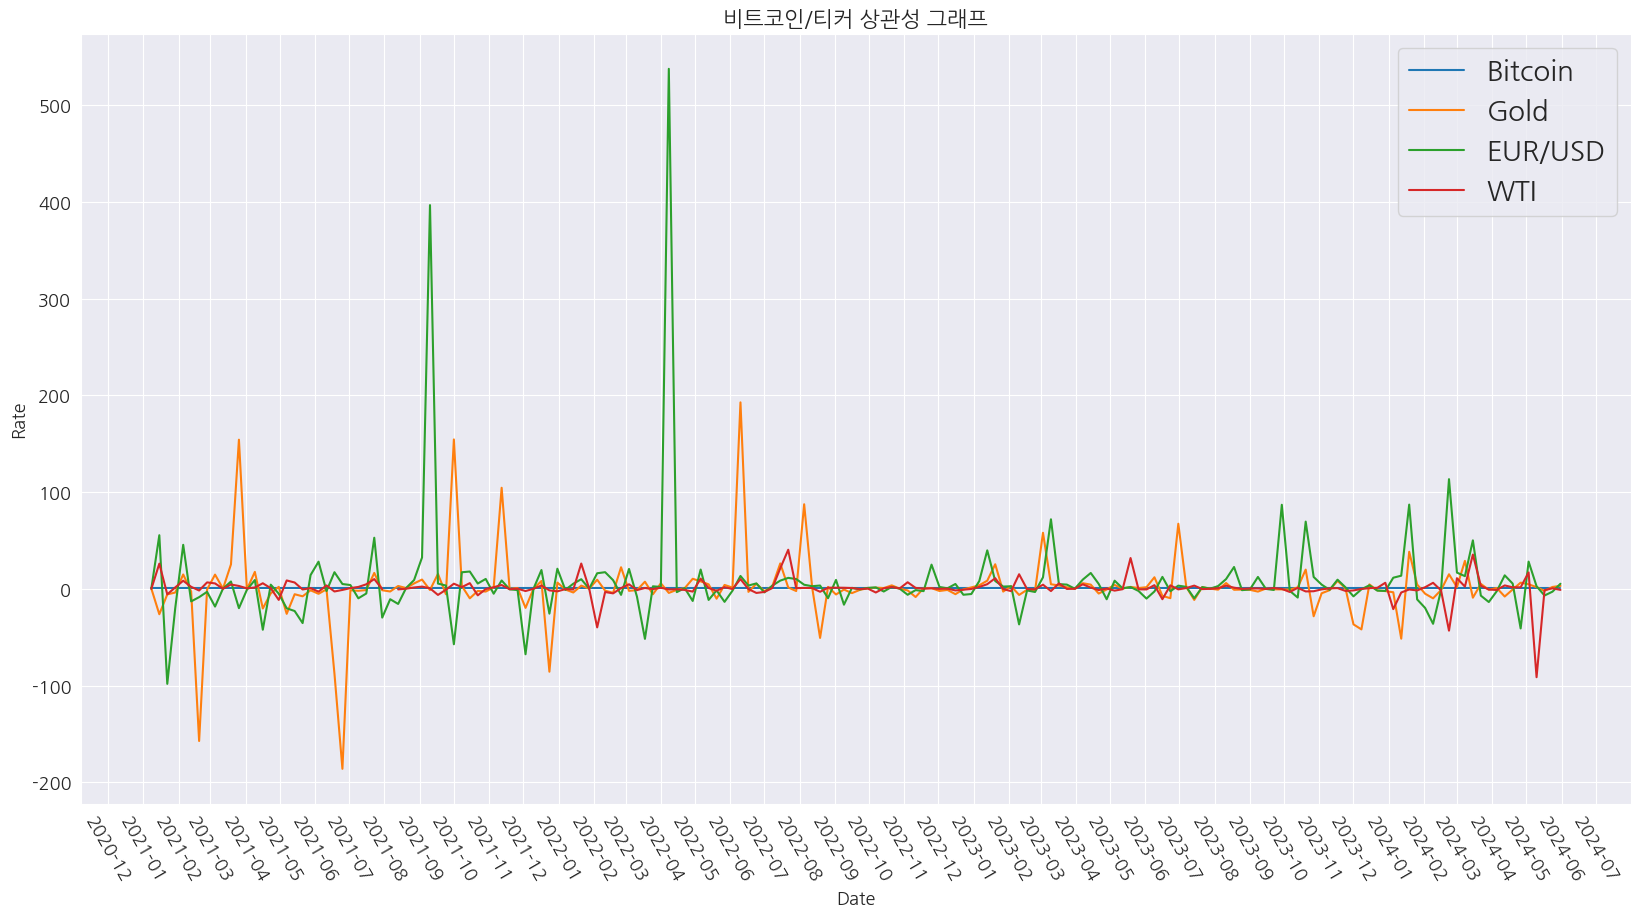

In [10]:
# 상관성 그래프 시각화
# weekly_return_rate(Bitcoin) / weekly_return_rate(ticker)
corr_y1 = corr_bit(bitcoin, start_date, end_date)
corr_y2 = corr_bit(gold, start_date, end_date)
corr_y3 = corr_bit(usd, start_date, end_date)
corr_y4 = corr_bit(wti, start_date, end_date)

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(corr_y1.index, corr_y1, label = "Bitcoin")
plt.plot(corr_y2.index, corr_y2, label = "Gold")
plt.plot(corr_y3.index, corr_y3, label = "EUR/USD")
plt.plot(corr_y4.index, corr_y4, label = "WTI")
plt.legend(loc = "best", prop = {"size":20})
plt.xlabel("Date")
plt.ylabel("Rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("비트코인/티커 상관성 그래프")
plt.show()

## 피어슨 상관 계수

In [11]:
# 비트코인과 티커의 상관 계수 산출
df_close = pd.concat([bit_ticker["Adj Close"], ticker["Adj Close"]], axis = 1)
df_close.columns = ["bit_adj_close", "tk_adj_close"]
df_close = df_close.dropna()
corr_coefficient = np.corrcoef(df_close["bit_adj_close"], df_close["tk_adj_close"])[0, 1]
print(f"비트코인과의 상관 계수 : {corr_coefficient:.4f}")

비트코인과의 상관 계수 : 0.5073


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


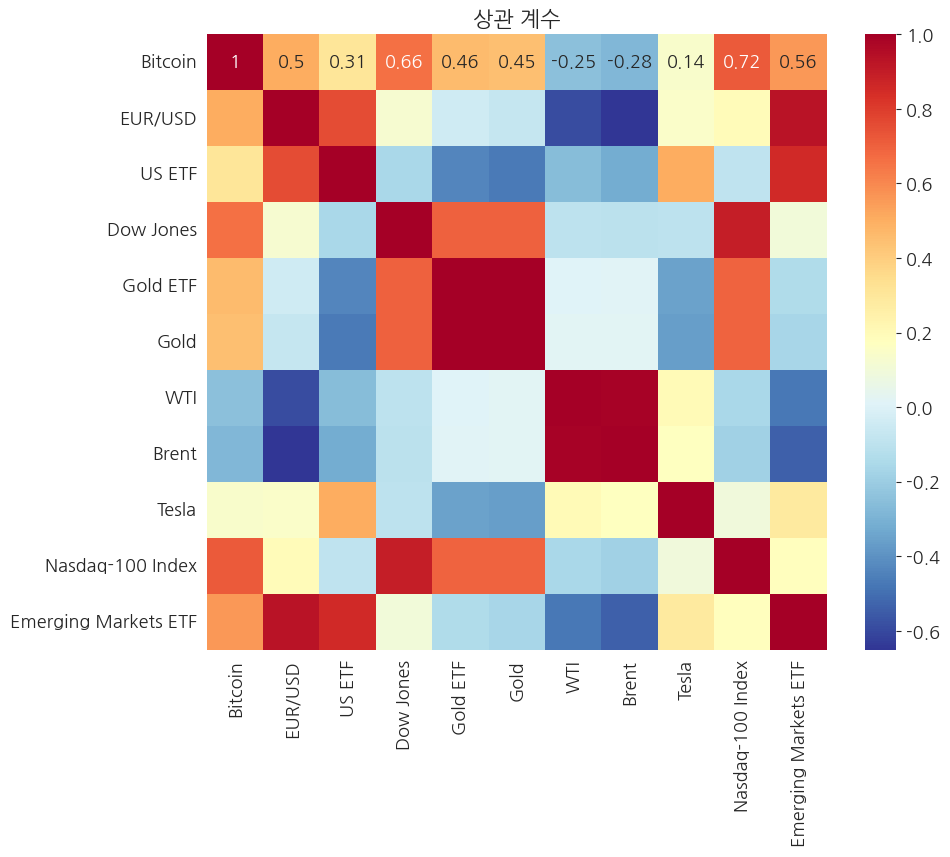

In [12]:
# 상관 계수 시각화 - HeatMep
corr_matrix = pd.DataFrame({"Bitcoin" : daily_adj_close(bitcoin, start_date, end_date),
                            # 안전자산
                            "EUR/USD" : daily_adj_close(usd, start_date, end_date),
                            "US ETF" : daily_adj_close("TLT", start_date, end_date),
                            "Dow Jones" : daily_adj_close("^DJI", start_date, end_date),
                            "Gold ETF" : daily_adj_close("GLD", start_date, end_date),
                            "Gold" : daily_adj_close(gold, start_date, end_date),
                            # 위험자산
                            "WTI" : daily_adj_close(wti, start_date, end_date),
                            "Brent" : daily_adj_close("BZ=F", start_date, end_date),
                            "Tesla" : daily_adj_close("TSLA", start_date, end_date),
                            "Nasdaq-100 Index" : daily_adj_close("QQQ", start_date, end_date),
                            "Emerging Markets ETF" : daily_adj_close("EEM", start_date, end_date)}).corr()

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = "RdYlBu_r", cbar = True)
plt.title("상관 계수")
plt.show()

## 뉴스 크롤링
- 티커의 변동성이 큰 날짜와 특정 날짜의 네이버 뉴스 크롤링

In [13]:
# 주간 티커 데이터 수집
ticker_wk = ticker_data_wk(usd, start_date, end_date)
ticker_wk

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,weekly_return
Date,,,,,,,
2021-01-08,1.226873,1.228215,1.211314,1.216249,1.216249,0,-1.447335
2021-01-15,1.215300,1.217196,1.205545,1.211563,1.211563,0,-0.385283
2021-01-22,1.216619,1.218800,1.206200,1.210507,1.210507,0,-0.087147
2021-01-29,1.212136,1.215701,1.196716,1.204239,1.204239,0,-0.517831
2021-02-05,1.196745,1.215099,1.195357,1.212121,1.212121,0,0.654551
...,...,...,...,...,...,...,...
2024-05-03,1.073307,1.080941,1.072501,1.074691,1.074691,0,0.236438
2024-05-10,1.078516,1.089681,1.076206,1.088981,1.088981,0,1.329638
2024-05-17,1.086779,1.089562,1.081303,1.082520,1.082520,0,-0.593222


In [14]:
# 상승, 하락이 관계 없는 주간 변동성 추출
ticker_chg_abs = (ticker_wk["Adj Close"].pct_change()*100).abs()
# 변동성 큰 구간 TOP6
large_chg = ticker_chg_abs.sort_values(ascending = False)
top6_chg = large_chg[:6]
top6_chg

Date
2022-11-11    3.747401
2022-10-21    3.332367
2022-10-28    2.750005
2022-04-22    2.716884
2023-03-17    2.712166
2023-02-03    2.697177
Name: Adj Close, dtype: float64

In [15]:
# 뉴스 크롤링 날짜 추가
news_date_list = pd.to_datetime(news_date_list, format="%Y.%m.%d").tolist()
top6_lst = top6_chg.index.to_list()
news_date_list.extend(top6_lst)
news_date_list

[Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-11-14 00:00:00'),
 Timestamp('2023-04-03 00:00:00'),
 Timestamp('2024-01-08 00:00:00'),
 Timestamp('2024-03-25 00:00:00'),
 Timestamp('2024-05-06 00:00:00'),
 Timestamp('2022-11-11 00:00:00'),
 Timestamp('2022-10-21 00:00:00'),
 Timestamp('2022-10-28 00:00:00'),
 Timestamp('2022-04-22 00:00:00'),
 Timestamp('2023-03-17 00:00:00'),
 Timestamp('2023-02-03 00:00:00')]

In [16]:
news_titles = []
search = input("뉴스 검색어 입력 (ex. 비트코인 달러) : ")

driver = wb.Chrome()
driver.maximize_window()
for i in tqdm(range(len(news_date_list))) :
    # 뉴스 검색 기간 : 지정된 날짜 포함 일주일
    news_ds = news_date_list[i]
    news_de = news_ds + datetime.timedelta(days = 6)
    driver.get(f"https://search.naver.com/search.naver?where=news&query={search}&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds={news_ds.strftime('%Y.%m.%d')}&de={news_de.strftime('%Y.%m.%d')}&docid=&related=0&mynews=0&office_type=0&office_section_code=0")
    
    body = driver.find_element(By.TAG_NAME, "body")
    try :
        # 스크롤
        for _ in range(10) :
            body.send_keys(Keys.END)
            time.sleep(1)
            
        # 뉴스 타이틀 수집
        titles = driver.find_elements(By.CSS_SELECTOR, "a.news_tit")
        for i in titles :
            news_titles.append(i.text)
    except Exception as e :
        print("오류 : ", e)
print("완료😇")
driver.quit()

100%|██████████| 12/12 [02:23<00:00, 12.00s/it]


완료😇


In [17]:
print(len(news_titles))
print(news_titles)

1298
['[IT큐레이션] 비트코인, 러시아 구원할까', '\'자칭 사토시\' 크레이그 라이트 "비트코인 쓸모 없어...110만 BTC 매도 계획"', "[코인시황] 큰손들 등장에 '비트코인' 상승세…5700만원대", "'비트코인 직접 투자 vs ETF 투자'…뭐가 더 유리할까?", "[빗썸 시세] 리플 소폭 하락 '비트코인 영향 분석'", "[위클리마켓뷰] 비트코인, 美·EU 규제에 '롤러코스터'", "달러도 영원할 수는 없다... 언젠가는 비트코인이 '킹 머니' 자리를? [기승전...", "비트코인 '세 번째 고래', 일주일 만 1500BTC 재차 매도", '코인 랠리 시작되나…전문가들 "심리적·기술적 요인 긍정적"', '"한국인 창업기업 대규모 매집"...비트코인 강세 \'환호\'', "[위클리마켓뷰] 비트코인, 美·EU 규제에 '롤러코스터'", '[코인브리핑] 비트코인 8일 연속 상승..5700만원 넘어서', '“지금이 저점 매수 타이밍?”, 기관 움직임에 비트코인 상승 시동 걸었다', '[코인시황] 비트코인, 호재 이어지며 석 달 만에 5600만원 돌파', "달러도 영원할 수는 없다... 언젠가는 비트코인이 '킹 머니' 자리를? [기승전...", '비트코인, 한때 4만8천달러 회복…연중 최고치', "비트코인 '세 번째 고래', 일주일 만 1500BTC 재차 매도", '[비트코인 지금] 가격 오르자 관련 ETF도 뛴다', '"코인 7500억원 털렸다"…돈버는 게임 \'엑시 인피니티\' 대규모 해킹', '코인 시세 쥐락펴락하는 거물…일론 머스크만이 아니네? 심지어 한국인!', '[오늘의 코인] 봄을 맞는 암호화폐 시장', "[빗썸 시세] '비트코인 영향 분석' 리플 소폭 상승", '마이클 세일러, 비트코인 구매 위해 2억500만 달러 담보 대출', "비트코인 껑충…'4월 불장' 기대감 활활", '마이클 세일러, "엘살바도르 비트코인 채권 발행계획 위험 내포"', '올해만 비트코인 10억달러 사들인 권도형은 누구?', "비트코인, 4만7천달러 넘겨…'테라

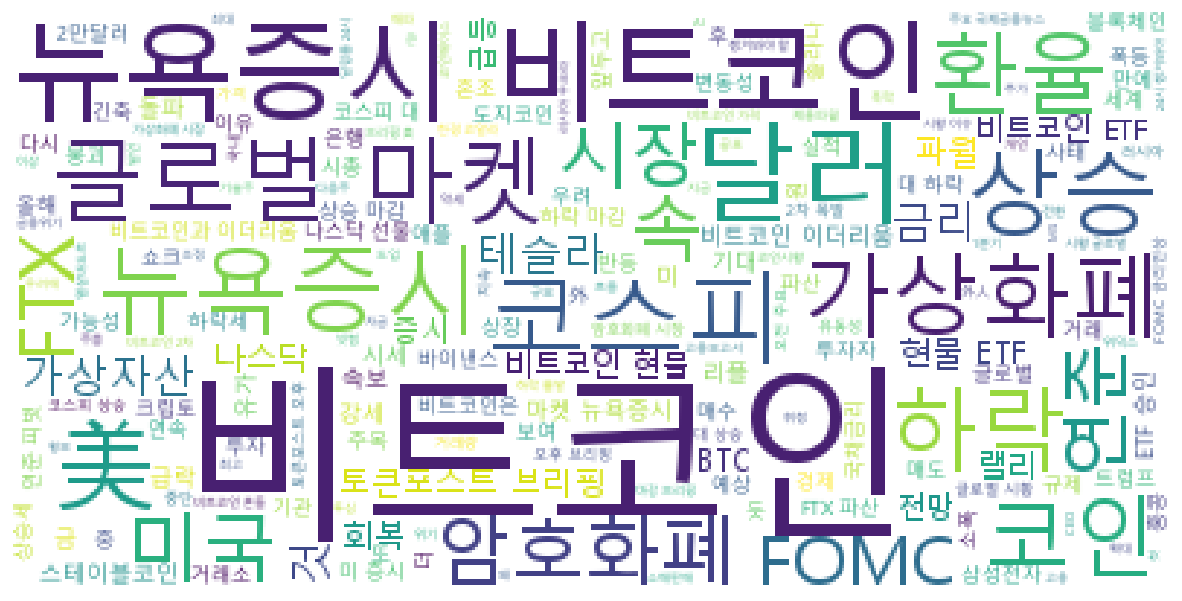

In [18]:
# 워드클라우드를 통한 핵심 키워드 시각화
text = ",".join(news_titles)
f_path = "C:\Windows\Fonts\malgun.ttf"

wc = WordCloud(font_path = f_path, random_state = 42, background_color = "white")
wc.generate(text)
plt.figure(figsize = (15, 10))
plt.axis("off")
plt.imshow(wc, interpolation = "None")
plt.show()